In [ ]:
!pip install "arize-phoenix[evals]>=3.20.0" gcsfs nltk langchain llama_index openai

In [ ]:
import json
import os
from getpass import getpass
from urllib.request import urlopen

import openai
import pandas as pd
import phoenix as px
from gcsfs import GCSFileSystem
from langchain.chat_models import ChatAnyscale
from llama_index import (
    ServiceContext,
    StorageContext,
    load_index_from_storage,
    set_global_handler,
)
from llama_index.embeddings import OpenAIEmbedding
from llama_index.graph_stores.simple import SimpleGraphStore
from llama_index.llms.anyscale import Anyscale
from tqdm import tqdm

# Configure Your OpenAI API Key

Set your OpenAI API key if it is not already set as an environment variable.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

# Sign up for Anyscale and Check Available Endpoints

Get your free token for an endpoint from Anyscale here, with your email
https://www.anyscale.com/endpoints

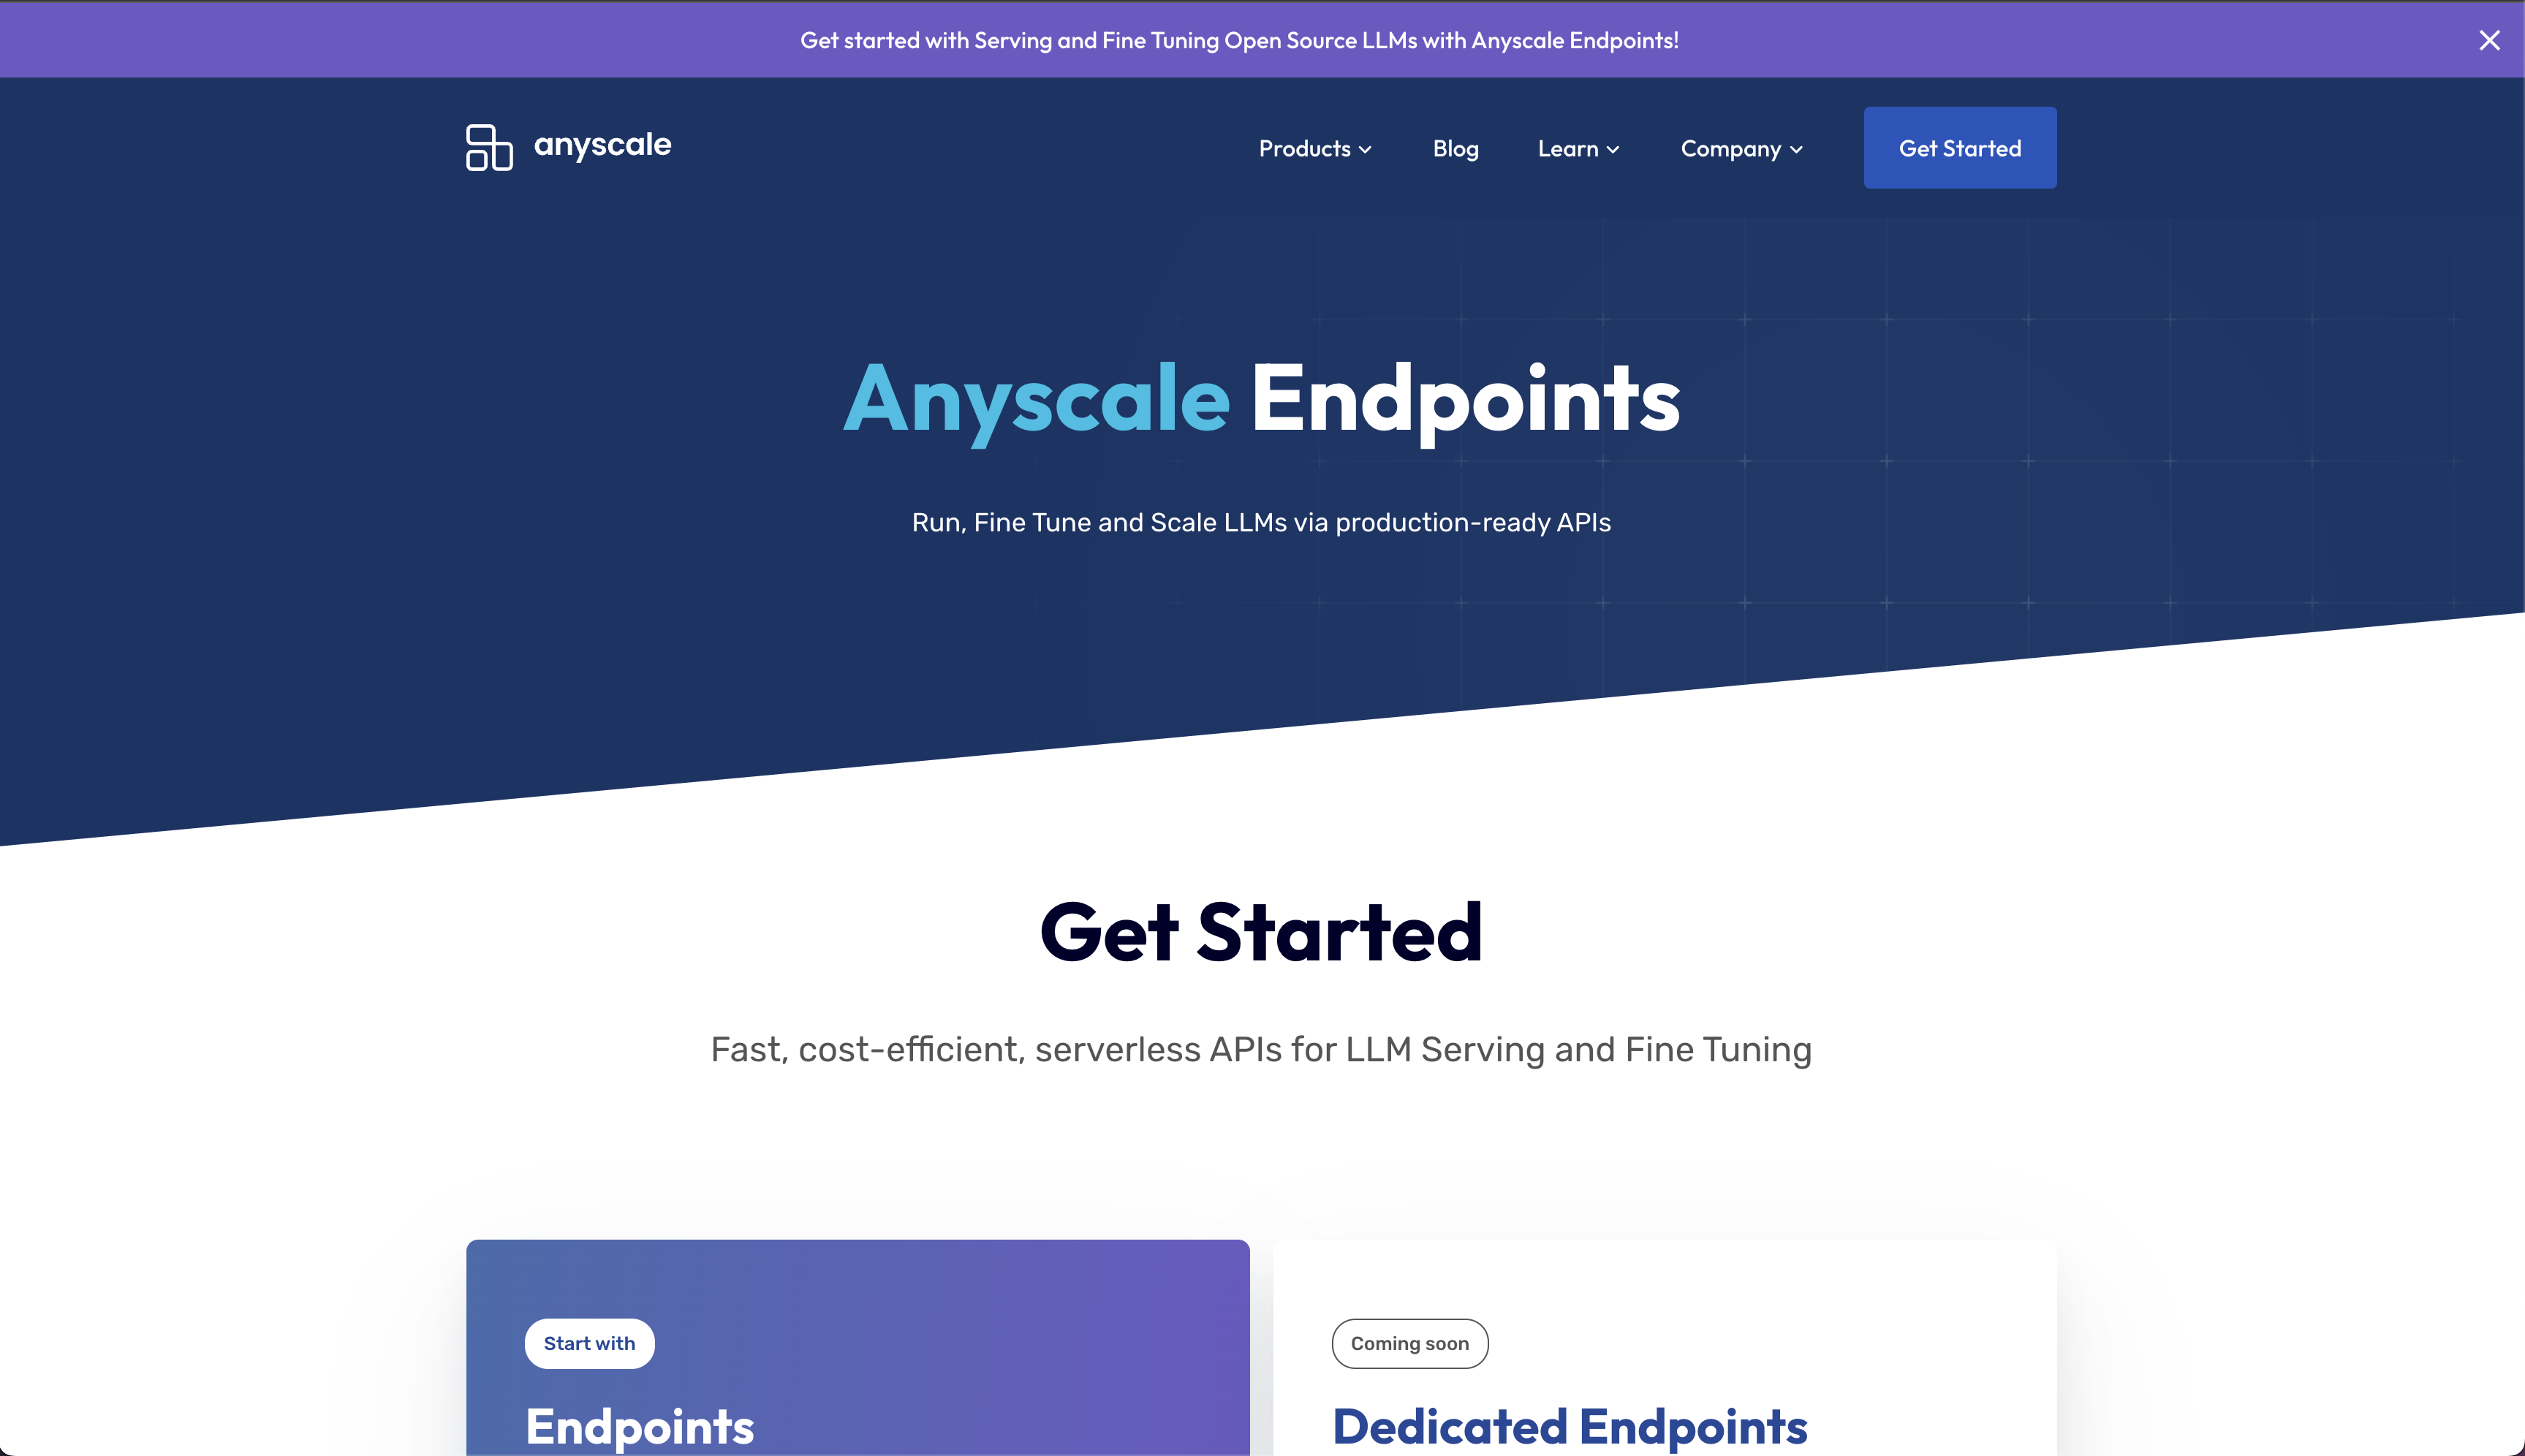

In [ ]:
ANYSCALE_ENDPOINT_TOKEN = "INSERT_ANYSCALE_ENDPOINT_TOKEN"


# List all models available
ChatAnyscale.get_available_models(anyscale_api_key=ANYSCALE_ENDPOINT_TOKEN)

# Grab some data

In [ ]:
queries_url = "http://storage.googleapis.com/arize-phoenix-assets/datasets/unstructured/llm/context-retrieval/arize_docs_queries.jsonl"
queries = []
with urlopen(queries_url) as response:
    for line in response:
        line = line.decode("utf-8").strip()
        data = json.loads(line)
        queries.append(data["query"])

sample_queries = queries[:3]

# Create Embeddings from Anyscale - General Text Embeddings (GTE) Large

In [ ]:
client = openai.OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1", api_key=ANYSCALE_ENDPOINT_TOKEN
)

response = client.embeddings.create(
    input=sample_queries,
    model="thenlper/gte-large",
)

print("Payload Response:", response)
print("Embeddings Dimensions:")
print([len(embedding.embedding) for embedding in response.data])

# Launch Phoenix and Build Llama RAG

In [ ]:
session = px.launch_app()

# Run this cell and Ignore the Error (Known Llama Issue)

The code did indeed run even though error message is displayed

In [ ]:
# Build knowledge base
file_system = GCSFileSystem(project="public-assets-275721")
index_path = "arize-phoenix-assets/datasets/unstructured/llm/llama-index/arize-docs/index/"
storage_context = StorageContext.from_defaults(
    fs=file_system,
    persist_dir=index_path,
    graph_store=SimpleGraphStore(),  # prevents unauthorized request to GCS
)

Enable Phoenix tracing within LlamaIndex by setting `arize_phoenix` as the global handler. This will mount Phoenix's [OpenInferenceTraceCallback](https://docs.arize.com/phoenix/integrations/llamaindex) as the global handler. Phoenix uses OpenInference traces - an open-source standard for capturing and storing LLM application traces that enables LLM applications to seamlessly integrate with LLM observability solutions such as Phoenix.

In [ ]:
set_global_handler("arize_phoenix")

We are now ready to instantiate our query engine that will perform retrieval-augmented generation (RAG). Query engine is a generic interface in LlamaIndex that allows you to ask question over your data. A query engine takes in a natural language query, and returns a rich response. It is built on top of Retrievers. You can compose multiple query engines to achieve more advanced capability  

In [ ]:
service_context = ServiceContext.from_defaults(
    llm=Anyscale(model="meta-llama/Llama-2-70b-chat-hf", api_key=ANYSCALE_ENDPOINT_TOKEN),
    embed_model=OpenAIEmbedding(),
)
index = load_index_from_storage(
    storage_context,
    service_context=service_context,
)
query_engine = index.as_query_engine()

# Run our queries and see them populate in Arize Phoenix

In [ ]:
for query in tqdm(sample_queries):
    query_engine.query(query)

And just for fun, ask your own question!

In [ ]:
response = query_engine.query("What is Arize and how can it help me as an AI and LLM Engineer?")
print(response)

### Make sure to check out your traces and spans in the Phoenix Traces View
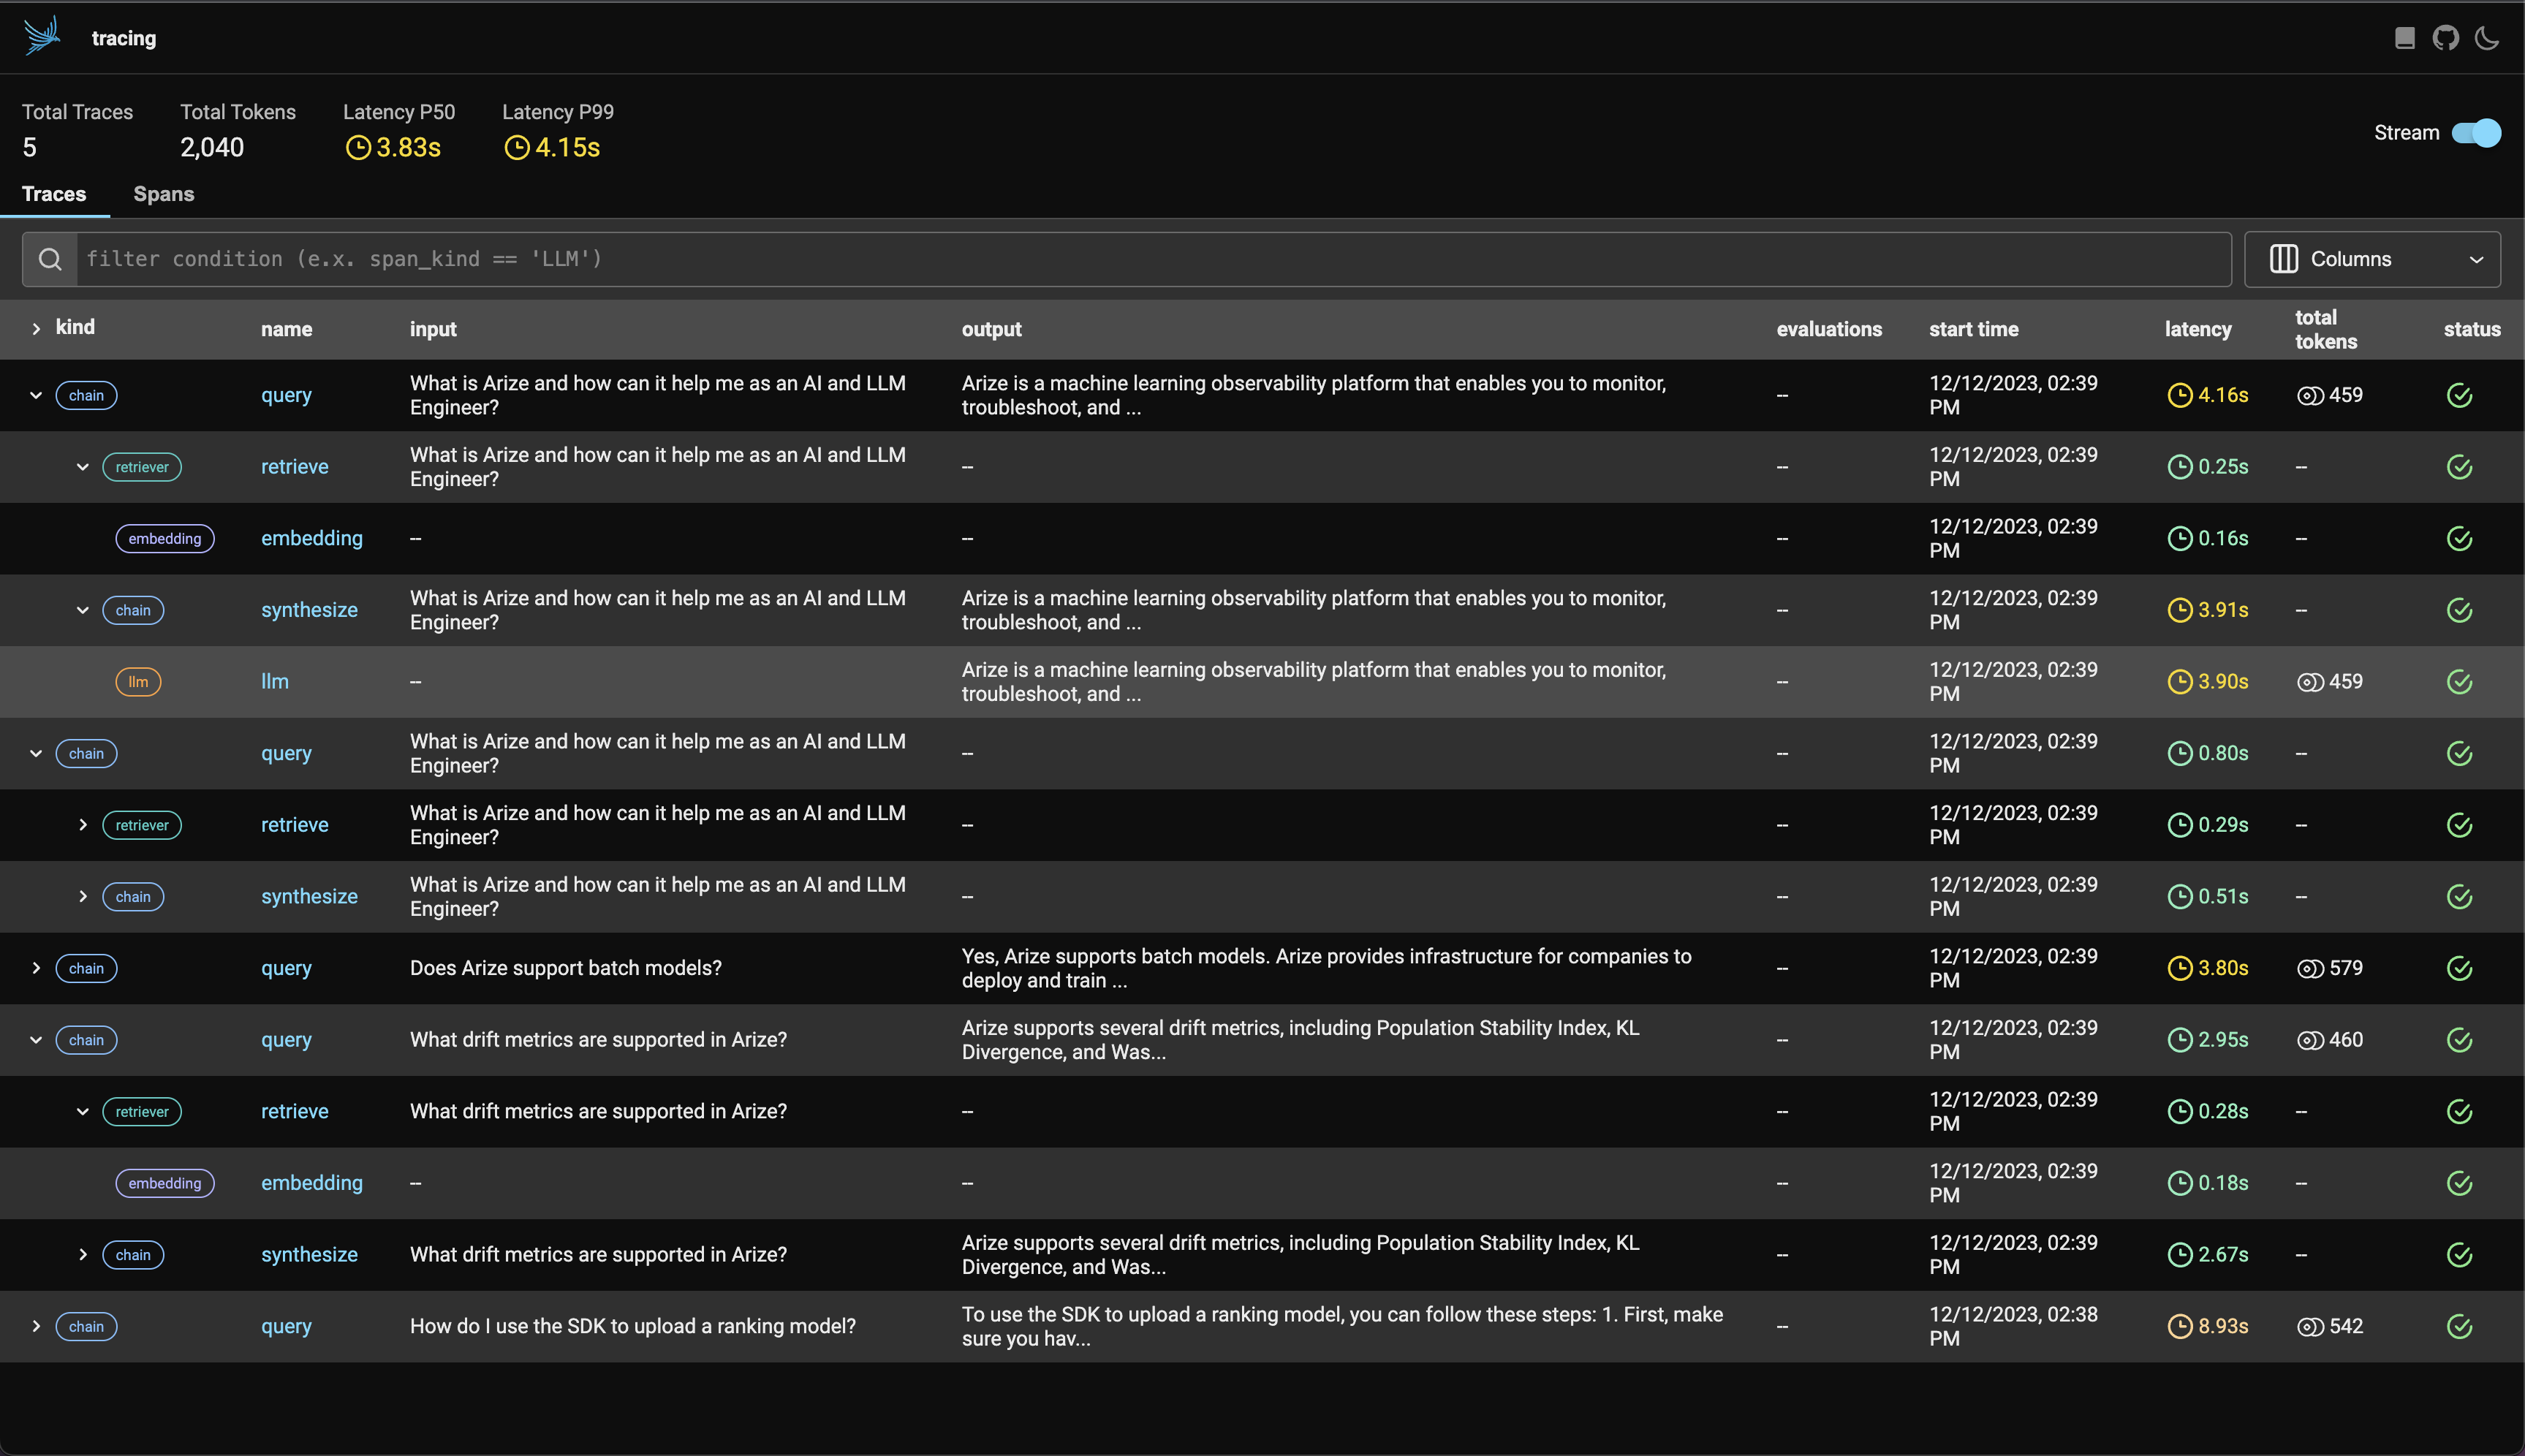

# Phoenix Embeddings View

Next we'll inspect our data at an application view using Arize Phoenix Embeddings and debugger. In this dataset we have prompt, responses, emebddings, LLM Evals, and more. We want to visualize our entire dataset in Phoenix Embeddings view

In [ ]:
data_url = (
    "https://storage.googleapis.com/arize-assets/fixtures/Embeddings/"
    "arize-demo-models-data/GENERATIVE/prompt-response/"
)
prod_df = pd.read_parquet(data_url + "df_queries_with_retrieved_doc_ids.parquet")

prod_df

In [ ]:
tag_columns = [
    "cost_per_call",
    "euclidean_distance_0",
    "euclidean_distance_1",
    "instruction",
    "openai_precision_1",
    "openai_precision_2",
    "openai_relevance_0",
    "openai_relevance_1",
    "prompt_template",
    "prompt_template_name",
    "retrieval_text_0",
    "retrieval_text_1",
    "text_similarity_0",
    "text_similarity_1",
    "user_query",
    "is_hallucination",
    "llm_config_model_name",
    "retrieved_doc_ids",
]

schema = px.Schema(
    prediction_id_column_name="prediction_id",
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="pred_label",
    tag_column_names=tag_columns,
    embedding_feature_column_names={
        "prompt_vector": px.EmbeddingColumnNames(
            vector_column_name="prompt_vector", raw_data_column_name="prompt_text"
        ),
    },
)

# Launch the Pheonix Embeddings View

In [ ]:
prod_ds = px.Inferences(dataframe=prod_df, schema=schema, name="production")
session = px.launch_app(primary=prod_ds)